# Twitter Sentiment Analysis

Authors: Jeonwook Kang, Mendy Nemanow, Zach Hanly

## Overview
We used twitter data in order to build a model that performs sentiment analysis. The data we used can be found here and was previously labeled with sentiments by other contributors. From those contributors of the data set:

>"Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion."

## Business and Data Understanding
Companies always want to have feedback from customers, and are constantly sending out surveys. In todays day and age, we believe the best feedback you can get from people is them talking about your product online, since it is less formal and you don't need to spend time asking costumers to take surveys. 


We created a model which can help companies analyze tweets about their company and products. this will help the social media department filter through tweets that reference their company and/or their products and find potentially negative tweets so that they may then address them and kepp their costumers happy. 

For this reason we set our model to proioritize identifying the negative tweets.

In [22]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
import re
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Data Cleaning

We got this data from data.world

In [5]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
# rename columns for my sanity 
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# clean sentiment value names
sentiment_replace = {'Positive emotion': 'positive', 'Negative emotion': 'negative'}
df.sentiment.replace(sentiment_replace, inplace=True)

In [7]:
df.isna().sum()

text            1
product      5802
sentiment       0
dtype: int64

In [8]:
df.sentiment.value_counts()

No emotion toward brand or product    5389
positive                              2978
negative                               570
I can't tell                           156
Name: sentiment, dtype: int64

There are alot of null in the product column, however we don't think we will make much use of it so the obvious choice is to drop that column.

We also will start with just the positive and negative tweets so that we have a binary classifier, and we'll get back to the neutral tweets later.

In [9]:
corpus = df[(df.sentiment == 'positive') | (df.sentiment == 'negative')].drop('product', axis=1)
corpus.head()

,text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,positive
3,@sxsw I hope this year's festival isn't as cra...,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive


Because we are trying to filter out the negative tweets, we want to say that the negative tweets are 1 and positive tweets are 0.


In [10]:
corpus.sentiment.replace(('negative', 'positive'), (1, 0), inplace=True)
corpus.sentiment.value_counts(normalize=True)

0    0.839346
1    0.160654
Name: sentiment, dtype: float64

The data is heavily imbalanced towards positive tweets. We will have to keep that in mind when createing our model.

## Pre-processing/Vectorizing

In order to make text data useable for training a model, we need to vectorize each text, by making each word that apears in the text a feature of that vector. The model can then learn which words imply a specific sentiment.

We want to make sure that the computer doesn't count words that are slightly different, but have the same meaning, as different words. For example "word" and "words" will be considered different features in the vector, if we let it. A similar problem, is words with capital letters or punctuations.

Sklearns CountVectorizer will solve these problems for us.

In [11]:
# split the data for training and testing
X = corpus.text
y = corpus.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [12]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test = cv.transform(X_test)
df_cv = pd.DataFrame(cv_X_train.toarray(), columns=cv.get_feature_names())

Here's a look at some of the most common words from the tweets we have.

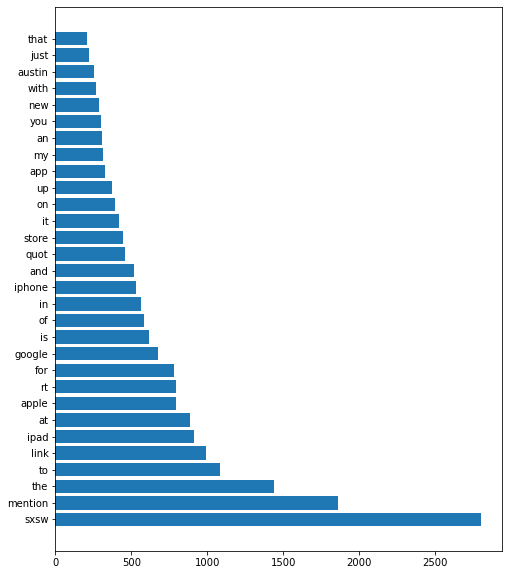

In [13]:
plt.figure(figsize=(8,10))
plt.barh(df_cv.sum().sort_values(ascending=False)[:30].index, df_cv.sum().sort_values(ascending=False)[:30]);

You can see that many of these words are what we call stop-words. Words like "the", "to", "at", "for", these words will not help the machine learn what the sentiment of the tweet is since these words are used in any sentence no matter the context.

We can remove all the stopwords from our CountVectorizer and keep only the more important words.

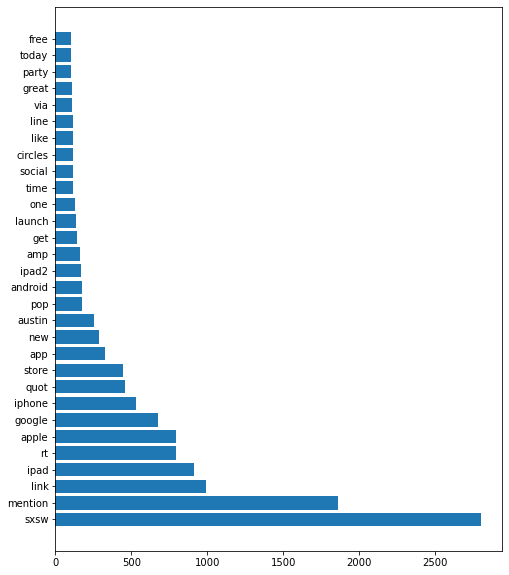

In [14]:
sw = stopwords.words('english')
sw_cv = CountVectorizer(stop_words=sw)
sw_cv_X_train = sw_cv.fit_transform(X_train)
sw_cv_X_test = sw_cv.transform(X_test)
sw_df_cv = pd.DataFrame(sw_cv_X_train.toarray(), columns=sw_cv.get_feature_names())
plt.figure(figsize=(8,10))
plt.barh(sw_df_cv.sum().sort_values(ascending=False)[:30].index, sw_df_cv.sum().sort_values(ascending=False)[:30]);

The CountVectorizer from sklearn automatically preprocesses, and tokenizes the words. It is possible that preprocessing on our own will have some different results. Let's try using our own Lemmatizer and our own pattern for the Tokenizer and compare the results.

In [15]:
# This function the correct Part of Speech so the Lemmatizer in the next function can be more accurate.
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def tweet_prep(tweet, stop_words=sw):
    '''
    
    :param tweet: a single tweet from thecorpus 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

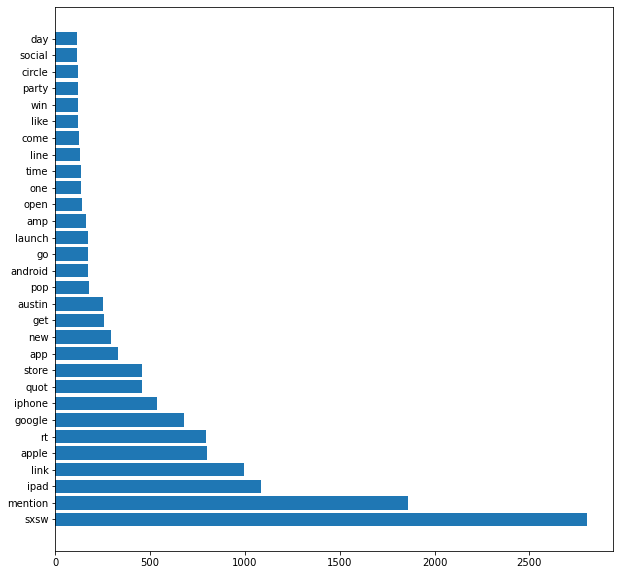

In [17]:
token_tweets = [tweet_prep(tweet, sw) for tweet in X_train]
X_train_vec = cv.fit_transform(token_tweets)
X_test_vec = cv.transform(X_test)
df_cv = pd.DataFrame(X_train_vec.toarray(), columns=cv.get_feature_names())
plt.figure(figsize=(10,10))
plt.barh(df_cv.sum().sort_values(ascending=False)[:30].index, df_cv.sum().sort_values(ascending=False)[:30]);

You can see that the most common words are mostly the same using the defaults from the CountVectorizer. For now will go with the default.

## Modeling

### Dummy Model

We start with a baseline model which we set to blindly predict half positive half negative. 

We'll work our way up from there.

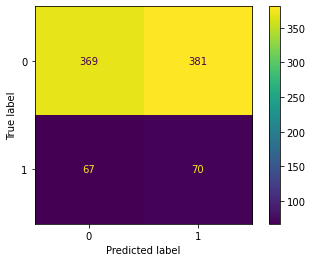

In [19]:
dummy = DummyClassifier(strategy='uniform', random_state=42)
dummy.fit(X_train_vec, y_train)
y_pred_dummy_sm = dummy.predict(X_test_vec)
plot_confusion_matrix(estimator=dummy, X=X_test_vec, y_true=y_test);

Naive Bayes is the simplest and fastest classification algorithm for a large chunk of data. In various applications such as spam filtering, text classification, sentiment analysis, and recommendation systems, Naive Bayes classifier is used successfully. It uses the Bayes probability theorem for unknown class prediction.

We know that getting a high accuracy will not be difficult because of the class imbalance which we noted earlier. The model will take in to acount the priors of each class and lean heavily towards positive classification. But it won't be able to identify the negative tweets very well. 

We can fix this by adjusting the priors of the algorithm. We'll run a grid search that will find the priors get us the best recall score. We wrote a function to do this grid search and print the results.

In [75]:
def mnb(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {'class_prior': [[0.5,0.5],[0.45,0.55],[0.4,0.6],[0.35,0.65], [0.3,0.7],[0.25,0.75]]}
    
    # Instantiate MultinomialNB model 
    mnb = MultinomialNB()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=mnb, param_grid=grid, cv=cv, scoring='recall')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    print(f'Best parameters: {gs.best_params_}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    score = gs.score(X_test, y_test)
    print(f'Test f1: {score}')
    recall = recall_score(y_test, y_pred)
    print(f'Recall Score: {recall}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score Score: {accuracy}')
    precision = precision_score(y_test, y_pred)
    print(f'Precision score: {precision}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    return {'Accuracy': round(100*accuracy,1), 'Sensitivity': round(100*recall,1)}

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.6698209035017375
Test f1: 0.6058394160583942
Recall Score: 0.6058394160583942
Accuracy score Score: 0.8117249154453213
Precision score: 0.42346938775510207


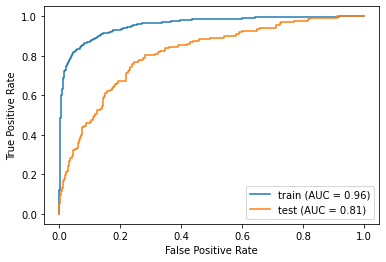

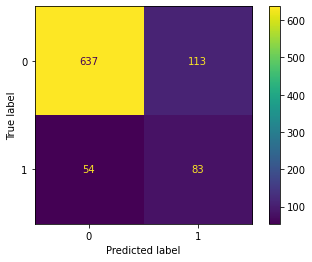

In [76]:
cv_mnb_results = mnb(X_train_vec, X_test_vec, y_train, y_test)

Even with adusting the priors we aren't able to get great recall scores. Another thing we can do to help class imbalance is to use SMOTE. This produces duplicates of the minority class to even out the classes. Then run the model again.

In [77]:
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm, y_train_sm = smote.fit_sample(X_train_vec, y_train) 
# notice the class imbalance is corrected
y_train_sm.value_counts()

1    2228
0    2228
Name: sentiment, dtype: int64

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.9067183957273139
Test f1: 0.6934306569343066
Recall Score: 0.6934306569343066
Accuracy score Score: 0.7305524239007892
Precision score: 0.3253424657534247


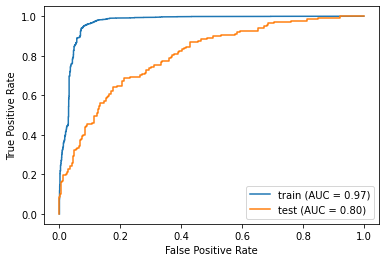

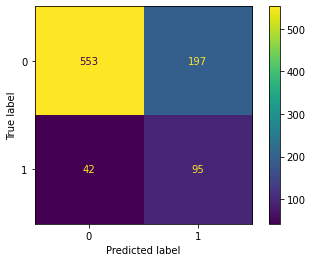

In [78]:
cv_mnb_sm_results = mnb(X_train_sm, X_test_vec, y_train_sm, y_test)

We see that our accuracy went down, but for our purposes this is better results because we are much better at identifying the negative tweets.

We can try a more sophisticated vectorizer, which may improve our results. We'll try it with and without the SMOTE. 
We will also try using different classifying algorithms.

In [79]:
tfidf = TfidfVectorizer(stop_words=sw)
tfidf_X_train = tfidf.fit_transform(X_train)
tfidf_X_test = tfidf.transform(X_test)
smote2 = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm2, y_train_sm2 = smote.fit_sample(tfidf_X_train, y_train)

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.8521785618818498
Test f1: 0.7956204379562044
Recall Score: 0.7956204379562044
Accuracy score Score: 0.7181510710259301
Precision score: 0.3293051359516616


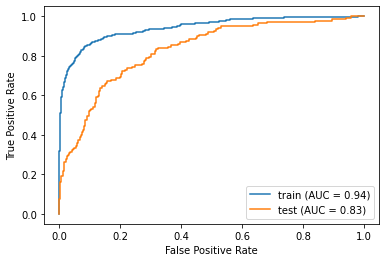

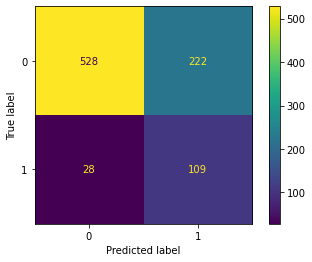

In [80]:
# This is without the SMOTE
tfidf_mnb_results = mnb(tfidf_X_train, tfidf_X_test, y_train, y_test)

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.9977558321156849
Test f1: 0.9124087591240876
Recall Score: 0.9124087591240876
Accuracy score Score: 0.5862457722660653
Precision score: 0.2604166666666667


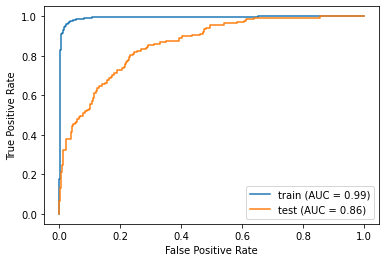

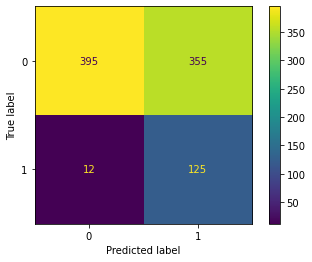

In [81]:
# This is with the SMOTE
tfidf_mnb_sm_results = mnb(X_train_sm2, tfidf_X_test, y_train_sm2, y_test)

Let's look at how the random foreset algorithm will perform. This is a much heavier model and will take a bit longer to run.

In [85]:
def random_forest(X_train, X_test, y_train, y_test):
    
    # The number of features to consider when looking for the best split
    n_estimators = [75,100,125]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Create the random grid
    grid = {'n_estimators': n_estimators,
                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
    
    # Instantiate random forest classifier 
    rf = RandomForestClassifier()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=rf, param_grid=grid, cv=5, scoring='recall')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    print(f'Best parameters: {gs.best_params_}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=5)
    print(f'Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    score = gs.score(X_test, y_test)
    print(f'Test f1: {score}')
    recall = recall_score(y_test, y_pred)
    print(f'Recall Score: {recall}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score Score: {accuracy}')
    precision = precision_score(y_test, y_pred)
    print(f'Precision score: {precision}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return {'Accuracy': round(100*accuracy,1), 'Sensitivity': round(100*recall,1)}

In [ ]:
# Random Forest with the CountVectorizer
import time
start = time.time()
cv_rf_results = random_forest(X_train_sm, X_test_vec, y_train_sm, y_test)
end = time.time()
print('Execution time = %.6f seconds' % (end-start))

In [ ]:
# Random Forest with the TF-IDF Vectorizer
tfidf_rf_results = random_forest(X_train_sm2, tfidf_X_test, y_train_sm2, y_test)

In [82]:
print(cv_mnb_results) 
print(cv_mnb_sm_results) 
print(tfidf_mnb_results)
print(tfidf_mnb_sm_results)

{'Accuracy': 81.0, 'Sensitivity': 61.0}
{'Accuracy': 73.0, 'Sensitivity': 69.0}
{'Accuracy': 72.0, 'Sensitivity': 80.0}
{'Accuracy': 59.0, 'Sensitivity': 91.0}


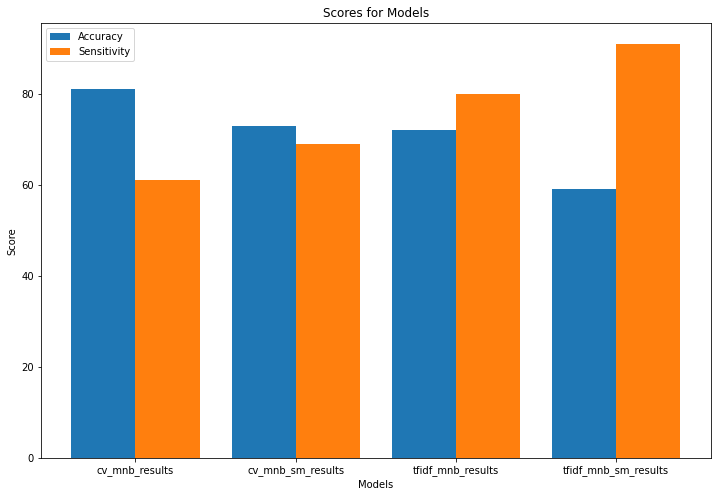

In [93]:
models = ['cv_mnb_results', 'cv_mnb_sm_results', 'tfidf_mnb_results', 'tfidf_mnb_sm_results']
accuracies = [81, 73, 72, 59]
sensitivities = [61, 69, 80, 91]
X_axis = np.arange(len(models))
  
plt.figure(figsize=(12,8))
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, sensitivities, 0.4, label = 'Sensitivity')
plt.xticks(X_axis, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Scores for Models")
plt.legend()
plt.show()

### In conclusion:
We can see that the results will be significanlty different depending on how you pre-process the data.

If you want to make sure that as many negative tweets as possible are identified, even if it means having to sift through extra tweets that we classified as negative that were in fact positive, then our model that used Naive Bayes, the TF-IDF Vectorizer and SMOTE, which is extremly sensitive to negative tweets. If you would prefer to have fewer tweets to look through, as long as you still pick up on most of the negatives, then you can use the Random Forest model that used TFIDF and SMOTE. Or you can go with the model Naive Bayes, TF-IDF without SMOTE which had more balanced results. Pretty accurate while still being very sensitive.

We imagine that different companies will prioritize different things.

## Next steps

There are a few things we'd still like to do. 
* Try different pre-processing steps to see if we can improve the results.
* Use different algorithms to see if any of them can outperform the ones we tried.
* Try to make a classifier that can also identify neutral tweets.
* See if we can figure out some use for the information about what the product is.